<a href="https://colab.research.google.com/github/pranavsouri/LSTM/blob/Jay/Timeseries_anomaly_detection_using_LSTM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__________

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np

np.random.seed(1)
tf.random.set_seed(1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.8.2


In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving amCharts (1).csv to amCharts (1) (3).csv


In [ ]:

df = pd.read_csv('amCharts (1).csv')

In [ ]:
# display top 5 and bottom 5 rows via function

def display_n(df,n): 
    with pd.option_context('display.max_rows',n*5):
        display(df)

display_n(df,2)

,TEST_PERIOD,TEST_PERIOD_FORMATTED,ATT_CONSISTANCY_1_5MB_MV,ATT_CONSISTANCY_5MB_MV,ATT_FAILED_PCT_MV,ATT_FAILED_TESTS_MV,ATT_HOSTED_PCT_MV,ATT_IMPACT_MV,ATT_JITTER_MV,ATT_LATENCY_MV,...,ATT_BINS100M_SUB6_MID_MV,TMO_BW_PCELL_10MHZ_MV,TMO_BW_PCELL_15MHZ_MV,TMO_BW_PCELL_20MHZ_MV,TMO_BW_PCELL_5MHZ_MV,VZ_BINS100M_SUB6_LOW_MV,FN_BINS100M_SUB6_LOW_MV,TMO_BINS100M_SUB6_LOW_MV,SP_BINS100M_SUB6_LOW_MV,SP_BW_PCELL_20MHZ_MV
0,19/07/02,02-Jul-19,77.78,77.78,80.28,57.0,40.00,-6.70,247.55,90.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19/07/03,03-Jul-19,52.63,26.32,17.07,7.0,84.21,-35.93,74.84,116.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19/07/04,04-Jul-19,85.71,78.57,20.69,6.0,50.00,-17.13,95.64,80.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19/07/05,05-Jul-19,53.33,33.33,43.33,13.0,78.95,-34.93,107.42,119.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19/07/06,06-Jul-19,90.00,70.00,28.57,4.0,92.86,-16.08,95.33,101.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,22/07/08,08-Jul-22,95.00,65.00,NaN,NaN,100.00,-100.00,21.62,95.75,...,NaN,NaN,NaN,0.0,NaN,500.0,300.0,100.0,NaN,NaN
1102,22/07/09,09-Jul-22,88.89,88.89,NaN,NaN,NaN,-40.77,34.90,145.56,...,NaN,NaN,NaN,0.0,NaN,1000.0,800.0,200.0,NaN,NaN
1103,22/07/10,10-Jul-22,100.00,92.31,NaN,NaN,50.00,-90.55,57.24,79.15,...,NaN,NaN,NaN,0.0,NaN,1000.0,300.0,300.0,NaN,NaN
1104,22/07/11,11-Jul-22,100.00,83.33,NaN,NaN,22.22,-85.20,20.74,85.58,...,NaN,NaN,NaN,0.0,NaN,1800.0,300.0,300.0,NaN,NaN


In [ ]:
df = df[['TEST_PERIOD_FORMATTED', 'ATT_TP_DL_MV']]
df = df.dropna()

In [ ]:
df.dtypes

TEST_PERIOD_FORMATTED     object
ATT_TP_DL_MV             float64
dtype: object

In [ ]:
# convert object to datetime format

df['TEST_PERIOD_FORMATTED'] = pd.to_datetime(df['TEST_PERIOD_FORMATTED'])

In [ ]:
df.dtypes

TEST_PERIOD_FORMATTED    datetime64[ns]
ATT_TP_DL_MV                    float64
dtype: object

In [ ]:
# Time horizon (start -> end)

df['TEST_PERIOD_FORMATTED'].min(), df['TEST_PERIOD_FORMATTED'].max()

(Timestamp('2019-07-02 00:00:00'), Timestamp('2022-07-12 00:00:00'))

In [ ]:
# Interactive chart (plotly): Close Price 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['TEST_PERIOD_FORMATTED'], y=df['ATT_TP_DL_MV'], name='DL Throughput'))
fig.update_layout(showlegend=True, title='ATT DL Throughput 2019-2022')
fig.show()

In [ ]:
train, test = df.loc[df['TEST_PERIOD_FORMATTED'] <= '2021-12-12'], df.loc[df['TEST_PERIOD_FORMATTED'] > '2021-12-12']

In [ ]:
# display train tail & head

def display_train(train,n): 
    with pd.option_context('display.max_rows',n*5):
        display(train)

display_n(train,2)

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV
0,2019-07-02,29.55
1,2019-07-03,6.20
2,2019-07-04,23.70
3,2019-07-05,7.70
4,2019-07-06,19.25
...,...,...
889,2021-12-08,44.78
890,2021-12-09,28.62
891,2021-12-10,46.05
892,2021-12-11,48.31


In [ ]:
train.shape,test.shape

((884, 2), (212, 2))

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train[['ATT_TP_DL_MV']])

train['ATT_TP_DL_MV'] = scaler.transform(train[['ATT_TP_DL_MV']])
test['ATT_TP_DL_MV'] = scaler.transform(test[['ATT_TP_DL_MV']])

In [ ]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['ATT_TP_DL_MV']], train['ATT_TP_DL_MV'])
X_test, y_test = create_sequences(test[['ATT_TP_DL_MV']], test['ATT_TP_DL_MV'])

In [ ]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (854, 30, 1)
Testing shape: (182, 30, 1)


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
24/24 [==============================] - 6s 116ms/step - loss: 0.7289 - val_loss: 0.9122
Epoch 2/100
24/24 [==============================] - 2s 78ms/step - loss: 0.6990 - val_loss: 0.8657
Epoch 3/100
24/24 [==============================] - 2s 79ms/step - loss: 0.6817 - val_loss: 0.8770
Epoch 4/100
24/24 [==============================] - 2s 73ms/step - loss: 0.6853 - val_loss: 0.8796
Epoch 5/100
24/24 [==============================] - 2s 78ms/step - loss: 0.6828 - val_loss: 0.8657


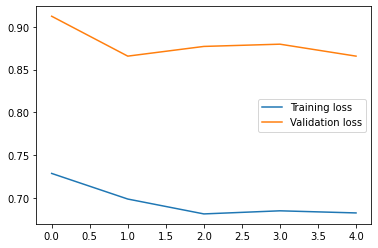

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 22ms/step - loss: 1.0542


1.0541858673095703

Reconstruction error threshold: 1.0651371325999694


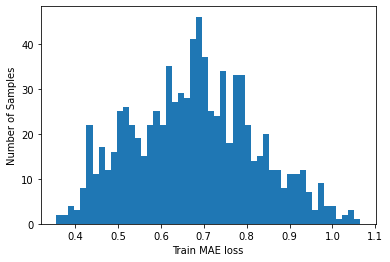

In [223]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
#threshold = 0.9
print(f'Reconstruction error threshold: {threshold}')

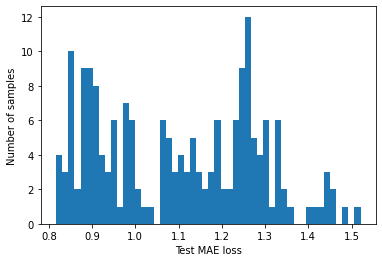

In [224]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [225]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['ATT_TP_DL_MV'] = test[TIME_STEPS:]['ATT_TP_DL_MV']

In [226]:
test_score_df.tail()

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV,loss,threshold,anomaly
1101,2022-07-08,0.708299,0.902156,1.065137,False
1102,2022-07-09,1.230490,0.875491,1.065137,False
1103,2022-07-10,0.178687,0.889173,1.065137,False
1104,2022-07-11,-0.949171,0.837492,1.065137,False
1105,2022-07-12,-0.592078,0.850604,1.065137,False


In [227]:
# Interactive chart (plotly): Test Loss & Treshold

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['TEST_PERIOD_FORMATTED'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['TEST_PERIOD_FORMATTED'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [228]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV,loss,threshold,anomaly
924,2022-01-12,4.007471,1.198516,1.065137,True
925,2022-01-13,0.977278,1.261282,1.065137,True
926,2022-01-14,0.690676,1.267135,1.065137,True
927,2022-01-15,1.229562,1.243262,1.065137,True
928,2022-01-16,-0.849927,1.254547,1.065137,True


In [229]:
anomalies.shape

(101, 5)

In [230]:
y_axis = scaler.inverse_transform(test_score_df[['ATT_TP_DL_MV']])
y_axis = y_axis.flatten()
y_axis_ana = scaler.inverse_transform(anomalies[['ATT_TP_DL_MV']])
y_axis_ana = y_axis.flatten()
y_axis.shape


(182,)

In [234]:
# Interactive chart (plotly): Close Price & Anomalies

fig = go.Figure()

fig.add_trace(go.Scatter(x=test_score_df['TEST_PERIOD_FORMATTED'], y= test_score_df['ATT_TP_DL_MV'], name='DL throughput'))
fig.add_trace(go.Scatter(x=anomalies['TEST_PERIOD_FORMATTED'], y=anomalies['ATT_TP_DL_MV'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()